<a href="https://colab.research.google.com/github/nandinib1999/edureka-assignments/blob/main/Sequence_Learning_Assignment_3_Image_Captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Downloaded dataset from https://www.kaggle.com/adityajn105/flickr8k

In [1]:
!unzip "/content/drive/MyDrive/image_caption.zip"

Streaming output truncated to the last 5000 lines.
  inflating: Images/2844846111_8c1cbfc75d.jpg  
  inflating: Images/2844963839_ff09cdb81f.jpg  
  inflating: Images/2845246160_d0d1bbd6f0.jpg  
  inflating: Images/2845691057_d4ab89d889.jpg  
  inflating: Images/2845845721_d0bc113ff7.jpg  
  inflating: Images/2846037553_1a1de50709.jpg  
  inflating: Images/2846785268_904c5fcf9f.jpg  
  inflating: Images/2846843520_b0e6211478.jpg  
  inflating: Images/2847514745_9a35493023.jpg  
  inflating: Images/2847615962_c330bded6e.jpg  
  inflating: Images/2847859796_4d9cb0d31f.jpg  
  inflating: Images/2848266893_9693c66275.jpg  
  inflating: Images/2848571082_26454cb981.jpg  
  inflating: Images/2848895544_6d06210e9d.jpg  
  inflating: Images/2848977044_446a31d86e.jpg  
  inflating: Images/2849194983_2968c72832.jpg  
  inflating: Images/2850719435_221f15e951.jpg  
  inflating: Images/2851198725_37b6027625.jpg  
  inflating: Images/2851304910_b5721199bc.jpg  
  inflating: Images/2851931813_eaf8ed

In [2]:
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
%matplotlib inline

import string
import os
import glob
from PIL import Image
from time import time

from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Embedding, Dense, Activation, Flatten, Reshape, Dropout
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import add
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [3]:
captions = "/content/captions.txt"
images_dir = "/content/Images"

In [4]:
len(os.listdir(images_dir))

8091

In [5]:
image_caption = open(captions,'r').readlines()
image_caption = [x.strip() for x in image_caption]
image_caption = [[x.split(',')[0], x.split(',')[1].lower()] for x in image_caption]
image_caption = image_caption[1:]
image_caption

[['1000268201_693b08cb0e.jpg',
  'a child in a pink dress is climbing up a set of stairs in an entry way .'],
 ['1000268201_693b08cb0e.jpg', 'a girl going into a wooden building .'],
 ['1000268201_693b08cb0e.jpg',
  'a little girl climbing into a wooden playhouse .'],
 ['1000268201_693b08cb0e.jpg',
  'a little girl climbing the stairs to her playhouse .'],
 ['1000268201_693b08cb0e.jpg',
  'a little girl in a pink dress going into a wooden cabin .'],
 ['1001773457_577c3a7d70.jpg', 'a black dog and a spotted dog are fighting'],
 ['1001773457_577c3a7d70.jpg',
  'a black dog and a tri-colored dog playing with each other on the road .'],
 ['1001773457_577c3a7d70.jpg',
  'a black dog and a white dog with brown spots are staring at each other in the street .'],
 ['1001773457_577c3a7d70.jpg',
  'two dogs of different breeds looking at each other on the road .'],
 ['1001773457_577c3a7d70.jpg',
  'two dogs on pavement moving toward each other .'],
 ['1002674143_1b742ab4b8.jpg',
  'a little girl 

In [7]:
import tqdm
import re

image_caption_dict = {}

for image_id, caption in tqdm.tqdm(image_caption, total=len(image_caption)):
  caption_pr = re.sub('[^0-9A-Za-z\s]', '', caption)
  if image_id in image_caption_dict.keys():
    image_caption_dict[image_id].append(caption_pr.strip())
  else:
    image_caption_dict[image_id] = [caption_pr.strip()]

100%|██████████| 40455/40455 [00:00<00:00, 409555.71it/s]


In [8]:
def image_desc_plotter():
  npic = 5
  npix = 224
  target_size = (npix,npix,3)

  count = 1
  fig = plt.figure(figsize=(10,20))
  for image_id in list(set(os.listdir(images_dir)))[:5]:
      filename = images_dir + '/' + image_id
      captions = list(image_caption_dict[image_id])
      image_load = load_img(filename, target_size=target_size)
      
      ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
      ax.imshow(image_load)
      count += 1
      
      ax = fig.add_subplot(npic,2,count)
      plt.axis('off')
      ax.plot()
      ax.set_xlim(0,1)
      ax.set_ylim(0,len(captions))
      for i, caption in enumerate(captions):
          ax.text(0,i,caption,fontsize=20)
      count += 1
  plt.show()

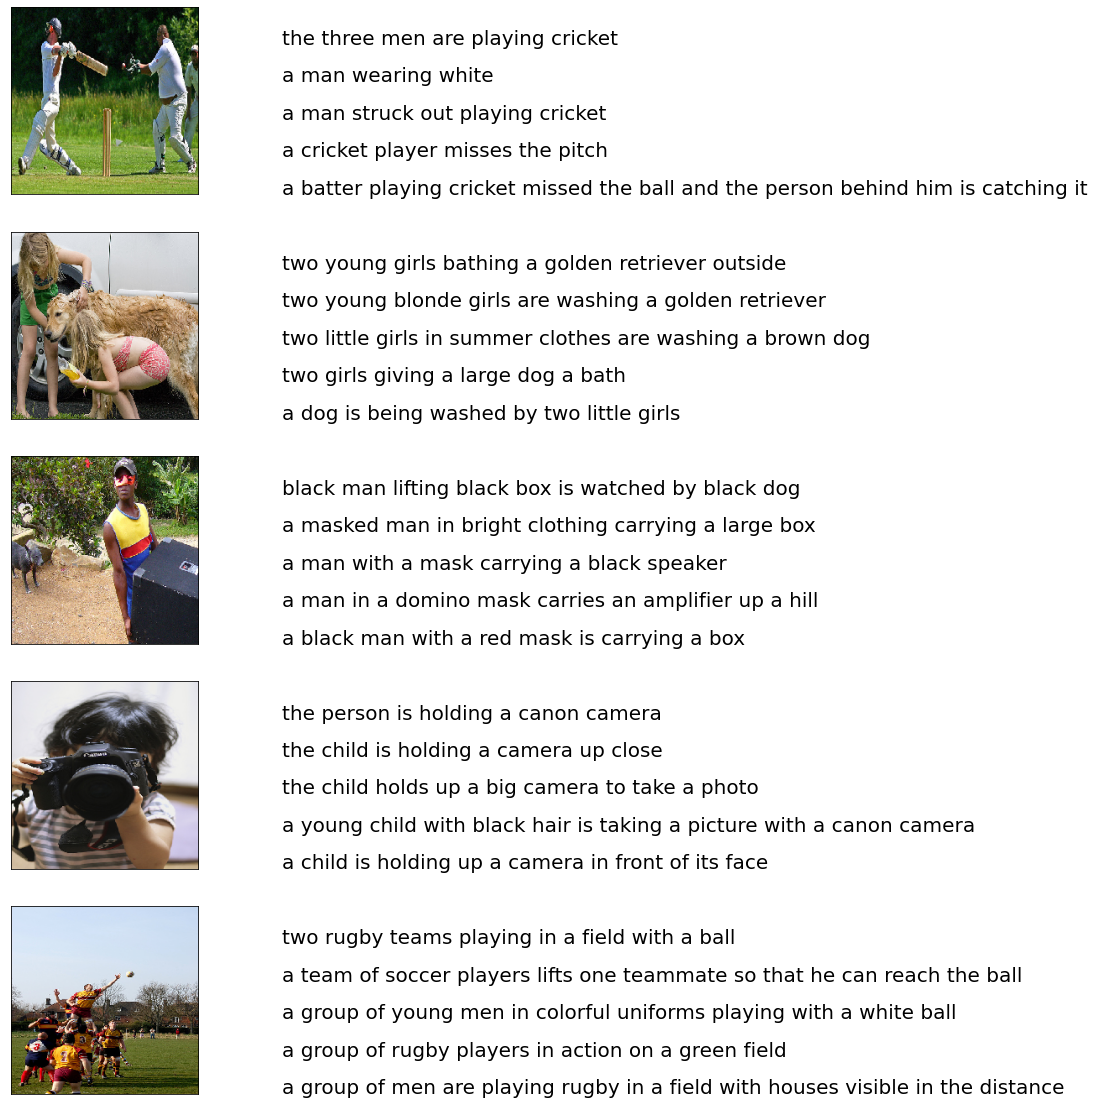

In [9]:
image_desc_plotter()

In [10]:
bad_key = []
for image_id in tqdm.tqdm(image_caption_dict.keys(), total=len(image_caption_dict)):
  if image_id not in os.listdir(images_dir):
    bad_key.append(image_id)

bad_key

100%|██████████| 8091/8091 [00:27<00:00, 292.87it/s]


[]

In [11]:
import random

items = list(image_caption_dict.items())  # List of tuples of (key,values)
random.shuffle(items)

In [55]:
if not os.path.exists("/content/drive/MyDrive/test_data.csv"):
  print("Creating training and validation sets")
  training_set = items[:6000]
  validation_set = items[6000:8000]
  print(len(training_set))
  print(len(validation_set))
  train_lst = [[image_id, caption] for image_id, captions in training_set for caption in captions]
  train_df = pd.DataFrame(train_lst, columns=["image", "caption"])
  print("Training Data", train_df.shape)
  train_df.to_csv("/content/drive/MyDrive/training_data.csv", index=False)

  val_lst = [[image_id, caption] for image_id, captions in validation_set for caption in captions]
  val_df = pd.DataFrame(val_lst, columns=["image", "caption"])
  print("Test Data", val_df.shape)
  val_df.to_csv("/content/drive/MyDrive/test_data.csv", index=False)
else:
  print("Loading training and validation sets")
  train_df = pd.read_csv("/content/drive/MyDrive/training_data.csv")
  val_df = pd.read_csv("/content/drive/MyDrive/test_data.csv")
  print("Training Data", train_df.shape)
  print("Test Data", val_df.shape)
  train_grp_df = train_df.groupby("image")
  training_set = []
  for image_id, data in train_grp_df:
    tmp = data['caption'].tolist()
    training_set.append([image_id, tmp])
  val_grp_df = val_df.groupby("image")
  validation_set = []
  for image_id, data in val_grp_df:
    tmp = data['caption'].tolist()
    validation_set.append([image_id, tmp])
  print(len(training_set))
  print(len(validation_set))

Loading training and validation sets
Training Data (30000, 2)
Test Data (10000, 2)
6000
2000


In [13]:
START_TAG = "<start>"
END_TAG = "<end>"

In [14]:
training_data = {}
for data in training_set:
  image_id, captions = data
  for caption in captions:
    caption = " ".join([START_TAG, caption, END_TAG])
    if image_id in training_data:
      training_data[image_id].append(caption)
    else:
      training_data[image_id] = [caption]

training_data

{'3648097366_706c8a57a1.jpg': ['<start> a boy doing a skateboard trick off of a flight of stairs while people watch <end>',
  '<start> a group of boys watch a skateboarder jump a distant staircase <end>',
  '<start> a skateboarder jumps the stairs <end>',
  '<start> several people watching as a skateboarder leaps down a flight of stairs <end>',
  '<start> spectators watch as a skateboarder does tricks <end>'],
 '447111935_5af98563e3.jpg': ['<start> the two greyhound dogs wearing sweaters are playing in the grass <end>',
  '<start> two dogs play in the grass <end>',
  '<start> two dogs wearing shirts play in the green grass <end>',
  '<start> two dogs wearing sweaters play in a field <end>',
  '<start> two dogs wearing sweaters play in the grass <end>'],
 '97406261_5eea044056.jpg': ['<start> a calico cat raising its paws towards a dog with an open mouth <end>',
  '<start> a cat swatting at a doberman dog <end>',
  '<start> a dog and cat are fighting on a chair <end>',
  '<start> a multi

In [15]:
test_data = {}
for data in validation_set:
  image_id, captions = data
  for caption in captions:
    caption = " ".join([START_TAG, caption, END_TAG])
    if image_id in test_data:
      test_data[image_id].append(caption)
    else:
      test_data[image_id] = [caption]

test_data

{'2629334536_11f2d49e05.jpg': ['<start> a baby in a blue shirt is in a swing <end>',
  '<start> a little blondeheaded child sits in the swing above the lush green grass <end>',
  '<start> a young girl plays on a swing <end>',
  '<start> a young person wearing shorts and a blue top is swinging in a child protector seat <end>',
  '<start> the little kid is swinging in the backyard <end>'],
 '2414986483_004936f84b.jpg': ['<start> a girl dances like a man in costume <end>',
  '<start> a little girl and a man dancing <end>',
  '<start> a man in a black suit dances with a young girl in plaid pants in an outdoor plaza <end>',
  '<start> the girl in the pink top is dancing with a man dressed in a blues brothers suit <end>',
  '<start> the little girl dances with a blues brothers impersonator <end>'],
 '3682277595_55f8b16975.jpg': ['<start> a brown and white dog trots across shallow water with his mouth open <end>',
  '<start> a brown spotted dog walks in shallow water <end>',
  '<start> a grey

In [16]:
vocabulary = []
max_len = 0
for captions in training_data.values():
  for caption in captions:
    sent = caption.split(" ")
    sent = [x.strip() for x in sent if len(x.strip()) > 0]
    if max_len < len(sent):
      max_len = len(sent)
    vocabulary.extend(sent)

In [17]:
max_len

35

In [18]:
vocab_set = list(set(vocabulary))
vocab_size = len(vocab_set)

In [21]:
import pandas as pd
from collections import Counter

def word_count(vocabulary):
    ct = Counter(vocabulary)
    words = []
    cnt = []
    for i, j in ct.items():
      if i != "<start>" and i != "<end>":
        words.append(i)
        cnt.append(j)
    data = {"word":words , "count":cnt}
    df = pd.DataFrame(data)
    df = df.sort_values(by='count', ascending=False)
    df = df.reset_index()[["word","count"]]
    return df

In [22]:
word_cnt = word_count(vocabulary)
word_cnt.head(10)

,word,count
0,a,45604
1,in,13552
2,the,13107
3,on,7619
4,is,6704
5,and,5960
6,dog,5883
7,with,5447
8,man,5319
9,of,4781


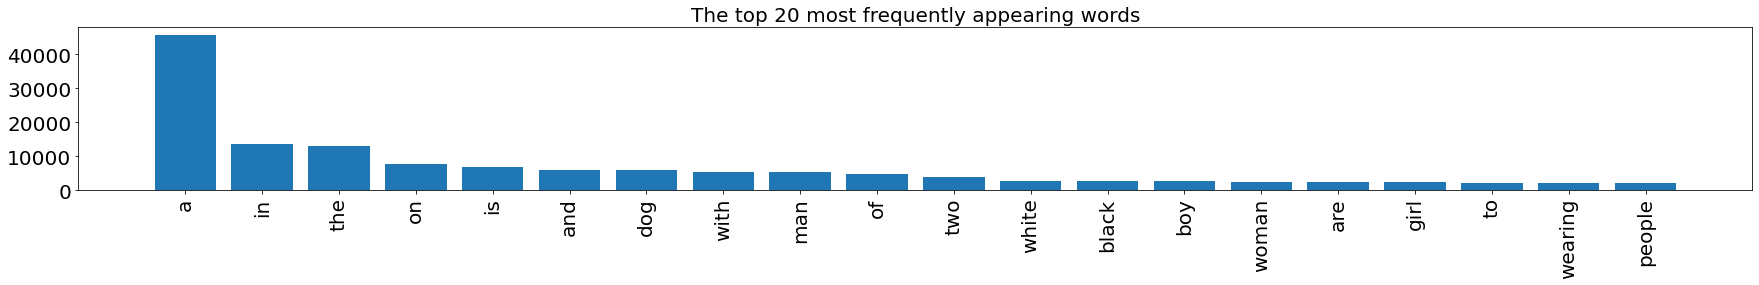

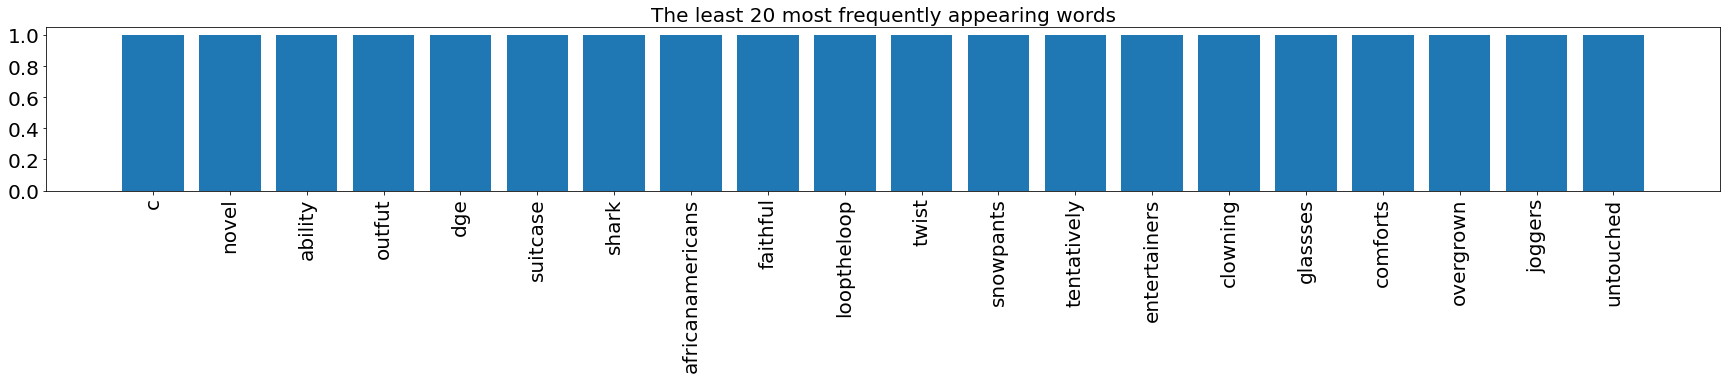

In [23]:
topn = 20

def plot_word_count(df, title):
    plt.figure(figsize=(30,3))
    plt.bar(df.index, df["count"])
    plt.yticks(fontsize=20)
    plt.xticks(df.index,df["word"], rotation=90, fontsize=20)
    plt.title(title, fontsize=20)
    plt.show()

plot_word_count(word_cnt[:topn], title="The top 20 most frequently appearing words")
print()
plot_word_count(word_cnt[-topn:], title="The least 20 most frequently appearing words")

In [24]:
idx2word = {}
word2idx = {}
for indx, word in enumerate(vocab_set):
    word2idx[word] = indx
    idx2word[indx] = word

In [25]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2021-06-05 19:34:10--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-06-05 19:34:10--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-06-05 19:34:10--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [26]:
embeddings_mapping = {} 
with open('glove.6B.200d.txt', encoding="utf-8") as fhead:
  for line in tqdm.tqdm(fhead):
      values = line.split()
      word = values[0]
      vector = np.asarray(values[1:], dtype='float32')
      embeddings_mapping[word] = vector

400000it [00:17, 22819.11it/s]


In [27]:
word2idx

{'frisbie': 0,
 'thorugh': 1,
 'tough': 2,
 'age': 3,
 'lapel': 4,
 'speaks': 5,
 'storefronts': 6,
 'studio': 7,
 'fourwheeler': 8,
 'positioned': 9,
 'consulting': 10,
 'skateboard': 11,
 'cup': 12,
 'circled': 13,
 'parachuter': 14,
 'car': 15,
 'black': 16,
 'curly': 17,
 'retrives': 18,
 'monitoring': 19,
 'winking': 20,
 'thin': 21,
 'longbearded': 22,
 'atv': 23,
 'sports': 24,
 'gothic': 25,
 'mcdonald': 26,
 'writes': 27,
 'starshaped': 28,
 'kept': 29,
 'dunked': 30,
 'sailing': 31,
 'aluminum': 32,
 'tram': 33,
 'horseback': 34,
 'roll': 35,
 'engulfed': 36,
 'biscuit': 37,
 'kong': 38,
 'skateboards': 39,
 'wheelchair': 40,
 'uncrowded': 41,
 'morning': 42,
 'crew': 43,
 'hummer': 44,
 'bolts': 45,
 'gate': 46,
 'flipped': 47,
 'backpacks': 48,
 'turn': 49,
 'shawl': 50,
 'swatting': 51,
 'groom': 52,
 'tonge': 53,
 'bended': 54,
 'pyranha': 55,
 'pees': 56,
 'mets': 57,
 'subdivsion': 58,
 'passing': 59,
 'spiky': 60,
 'walkways': 61,
 'bearded': 62,
 'schoolchildren': 63,

In [28]:
dim_embedd = 200
embedding_matrix = np.zeros((vocab_size, dim_embedd))
for word, i in tqdm.tqdm(word2idx.items(), total=len(word2idx)):
  if word in embeddings_mapping:
    embedding_vector = embeddings_mapping[word]
    embedding_matrix[i] = embedding_vector

100%|██████████| 7502/7502 [00:00<00:00, 340081.15it/s]


In [29]:
embedding_matrix.shape

(7502, 200)

In [30]:
base = InceptionV3(weights='imagenet')
encode_model = Model(base.input, base.layers[-2].output)

96116736/96112376 [==============================] - 2s 0us/step


In [31]:
# Standard utility functions

def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

def encode(image):
    image = preprocess(image) 
    vector = encode_model.predict(image) 
    vector = np.reshape(vector, vector.shape[1])
    return vector

In [56]:
encoded_train_data = {}
for image_id in tqdm.tqdm(training_data.keys(), total=len(training_data.keys())):
  encoded_train_data[image_id] = encode(os.path.join(images_dir, image_id))

100%|██████████| 6000/6000 [06:46<00:00, 14.77it/s]


In [57]:
import pickle

with open("/content/drive/MyDrive/encoded_images_train.pkl", "wb") as encoded_pickle:
  pickle.dump(encoded_train_data, encoded_pickle)

In [35]:
# import pickle

# with open('/content/drive/MyDrive/encoded_images_train.pkl', 'rb') as b:
#     encoded_train_data = pickle.load(b)

In [58]:
encoded_test_data = {}
for image_id in tqdm.tqdm(test_data.keys(), total=len(test_data.keys())):
  encoded_test_data[image_id] = encode(os.path.join(images_dir, image_id))

100%|██████████| 2000/2000 [02:06<00:00, 15.81it/s]


In [59]:
import pickle

with open("/content/drive/MyDrive/encoded_images_test.pkl", "wb") as encoded_pickle:
  pickle.dump(encoded_test_data, encoded_pickle)

In [38]:
# with open('/content/drive/MyDrive/encoded_images_test.pkl', 'rb') as b:
#     encoded_test_data = pickle.load(b)

In [60]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.3)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_len,))
se1 = Embedding(vocab_size, dim_embedd, mask_zero=True, weights=[embedding_matrix], trainable=False)(inputs2)
se2 = LSTM(128, return_sequences=True)(se1)
se3 = Dropout(0.2)(se2)
se4 = LSTM(256)(se3)

decoder1 = add([fe2, se4])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 35)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 35, 200)      1500400     input_5[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 35, 128)      168448      embedding_1[0][0]                
____________________________________________________________________________________________

In [61]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [62]:
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
  X1, X2, y = list(), list(), list()
  n=0
  # loop for ever over images
  while True:
      for key, desc_list in descriptions.items():
          n+=1
          # retrieve the photo feature
          photo = photos[key]
          for desc in desc_list:
              # encode the sequence
              seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
              # split one sequence into multiple X, y pairs
              for i in range(1, len(seq)):
                  # split into input and output pair
                  in_seq, out_seq = seq[:i], seq[i]
                  # pad input sequence
                  in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                  # encode output sequence
                  out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                  # store
                  X1.append(photo)
                  X2.append(in_seq)
                  y.append(out_seq)

          if n==num_photos_per_batch:
              yield ([array(X1), array(X2)], array(y))
              X1, X2, y = list(), list(), list()
              n=0

In [63]:
epochs = 30
batch_size = 256
steps = len(training_data)//batch_size

generator = data_generator(training_data, encoded_train_data, word2idx, max_len, batch_size)
history = model.fit(generator, epochs=epochs, steps_per_epoch=steps, verbose=1)

Epoch 1/30
23/23 [==============================] - 43s 2s/step - loss: 6.2794
Epoch 2/30
23/23 [==============================] - 34s 1s/step - loss: 5.3651
Epoch 3/30
23/23 [==============================] - 34s 1s/step - loss: 5.1089
Epoch 4/30
23/23 [==============================] - 33s 1s/step - loss: 4.8701
Epoch 5/30
23/23 [==============================] - 33s 1s/step - loss: 4.5243
Epoch 6/30
23/23 [==============================] - 33s 1s/step - loss: 4.1138
Epoch 7/30
23/23 [==============================] - 33s 1s/step - loss: 3.8559
Epoch 8/30
23/23 [==============================] - 34s 1s/step - loss: 3.6854
Epoch 9/30
23/23 [==============================] - 34s 1s/step - loss: 3.5524
Epoch 10/30
23/23 [==============================] - 33s 1s/step - loss: 3.4398
Epoch 11/30
23/23 [==============================] - 33s 1s/step - loss: 3.3415
Epoch 12/30
23/23 [==============================] - 33s 1s/step - loss: 3.2563
Epoch 13/30
23/23 [==============================

In [71]:
max_length = max_len

In [75]:
def greedySearch(photo):
    in_text = '<start>'
    for i in range(max_length):
        sequence = [word2idx[w] for w in in_text.split() if w in word2idx]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx2word[yhat]
        in_text += ' ' + word
        if word == '<end>':
            break

    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [73]:
def beam_search_predictions(image, beam_index = 3):
    start = [word2idx["<start>"]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_length, padding='post')
            preds = model.predict([image,par_caps], verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [idx2word[i] for i in start_word]
    final_caption = []
    
    for i in intermediate_caption:
        if i != '<end>':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [68]:
test_images = [k for k in encoded_test_data.keys()]
test_sample = test_images[:10]

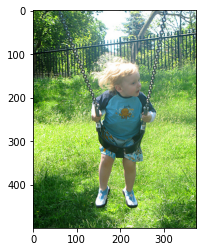

Greedy Search: a young boy is holding a swing on a swing
Beam Search, K = 3: a little girl in a blue shirt is playing on a swing
Beam Search, K = 5: a little girl in a blue shirt is playing on a swing
Beam Search, K = 7: a little girl in a blue shirt rides a swing
Beam Search, K = 10: a little girl in a blue shirt plays on a swing


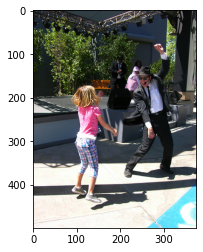

Greedy Search: a group of people are standing on a sidewalk
Beam Search, K = 3: a group of people are standing on a trampoline
Beam Search, K = 5: a group of people are walking on a sidewalk
Beam Search, K = 7: a group of people stand on a trampoline
Beam Search, K = 10: a group of people walking on a sidewalk


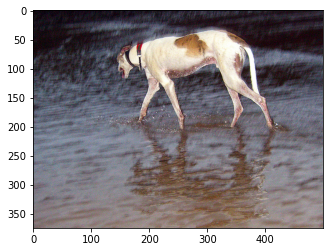

Greedy Search: a dog runs through the sand
Beam Search, K = 3: a brown dog is running through the water
Beam Search, K = 5: a white dog runs through the sand
Beam Search, K = 7: a white dog and a white dog are running on a beach
Beam Search, K = 10: a white dog and a white dog playing in the sand


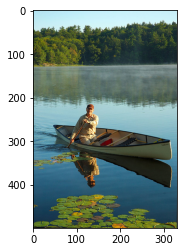

Greedy Search: a man is paddling through a lake
Beam Search, K = 3: a man paddles a canoe in the water
Beam Search, K = 5: a group of people are rowing in a lake
Beam Search, K = 7: a group of people riding a canoe
Beam Search, K = 10: a group of people riding a canoe


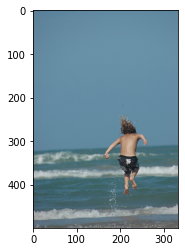

Greedy Search: a young boy is jumping into the water
Beam Search, K = 3: a young boy jumping into the water
Beam Search, K = 5: a young boy jumping into the water
Beam Search, K = 7: a young boy jumping into the water
Beam Search, K = 10: a young boy jumping into the water


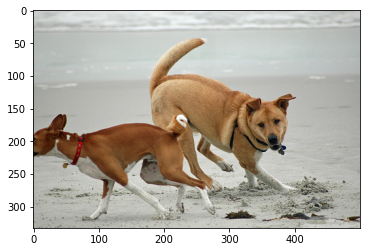

Greedy Search: a brown dog is running through the snow
Beam Search, K = 3: a brown dog is running through the snow
Beam Search, K = 5: a brown dog is running through the snow
Beam Search, K = 7: a brown dog and a brown dog playing in the grass
Beam Search, K = 10: a brown dog and a brown dog playing in the grass


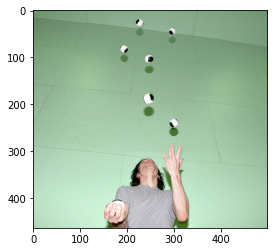

Greedy Search: a young boy in a yellow shirt is kicking a ball in a field
Beam Search, K = 3: a young boy in a yellow shirt is kicking a soccer ball
Beam Search, K = 5: a young boy kicks a ball
Beam Search, K = 7: a young boy kicks a ball
Beam Search, K = 10: a soccer player kicks a ball


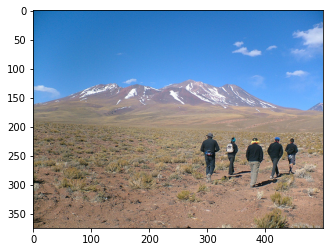

Greedy Search: a man stands on a mountaintop
Beam Search, K = 3: a group of people are standing on a mountain
Beam Search, K = 5: a group of people are standing on a mountain
Beam Search, K = 7: a group of people stand on a mountain
Beam Search, K = 10: a group of people sit on a mountain


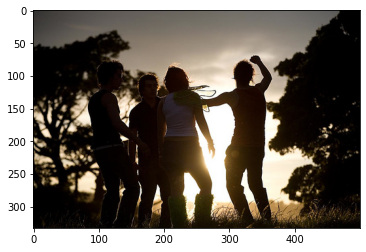

Greedy Search: a group of people are standing on a cliff
Beam Search, K = 3: a group of people are standing on a cliff
Beam Search, K = 5: a group of people are standing on a cliff
Beam Search, K = 7: a group of people standing in a field


In [ ]:
for pic in test_sample:  
  image = encoded_test_data[pic].reshape((1,2048))
  x=plt.imread(os.path.join(images_dir, pic))
  plt.imshow(x)
  plt.show()

  print("Greedy Search:",greedySearch(image))
  print("Beam Search, K = 3:",beam_search_predictions(image, beam_index = 3))
  print("Beam Search, K = 5:",beam_search_predictions(image, beam_index = 5))
  print("Beam Search, K = 7:",beam_search_predictions(image, beam_index = 7))
  print("Beam Search, K = 10:",beam_search_predictions(image, beam_index = 10))